## 文本分类, text-classification

这个例子是对 IMDB 数据集的影评进行分类，区别出正面和负面评论。数据集大小为 50000 条，将这些影评拆分成训练集和测试集各 25000 条。

我们合适了 [tf.keras](https://www.tensorflow.org/guide/keras) , 它为 TensorFlow 构建和训练模型提供高阶 API.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.__version__

'2.0.0-alpha0'

In [3]:
imdb = keras.datasets.imdb
(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words=10000)

### Have a look of our data

In [4]:
print("Training entries: {}, labels: {}".format(
    len(train_data),
    len(train_labels)
))

Training entries: 25000, labels: 25000


影评文本已经转换为整数，期中每一个整数都表示字典中的一个特定字词。

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


影评的长度可能会有所不同。以下代码显示了第一条和第二条影评中的字词数。由于神经网络的输入必须具有相同长度，因此我们稍后需要解决此问题。

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 将整数转换回字词

In [13]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserve, 将原有每个单词的值 +3
# 即偏移出 3 个位置。
word_index = {k:(v + 3) for k,v in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 #unkonwn
word_index["<UNUSED>"] = 3

reverse_word_index = dict(
    [value, key] for (key, value) in word_index.items()
)

def decode_review(text):
    return ' '.join([
        reverse_word_index.get(i, '?') for i in text
    ])

In [14]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 准备数据

影评 (整个数组) 必须转换成张量，然后才能传给神经网络。我们可以使用两种方法实现这种转换:

1. 对数组进行**独立热编码**，将它们转换为 0 和 1 构成的向量。例如，序列 [3, 5] 将变成一个 10000 维的向量，除索引 3 和 5 转换为 1 之外，其余全转换为 0。然后，将它作为网络的第一层，一个可以处理浮点向量数据的密集层。不过，这种方法会占用大量内存，需要一个大小为 num_words * num_reviews 的矩阵。

2. 或者，我们可以**填充数组**，使它们都具有相同的长度。然后创建一个形状为 `max_length * num_reviews` 的整数张量。我们可以使用一个能够处理这种形状的**嵌入层（embedding layer）**作为网络中的第一层。

下面我们使用 [pad_sequences](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 对数据进行预处理。

In [15]:
pad_seq = keras.preprocessing.sequence.pad_sequences

train_data = pad_seq(
    train_data,
    value=word_index['<PAD>'],
    padding='post', # pad 的值追加到后面
    maxlen=256,     # 超过长度的会被 truncate 截断。
)

test_data = pad_seq(
    test_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=256
)

In [19]:
print(len(train_data[0]), len(test_data[0]))

print(train_data[0])

256 256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  10

### 构建模型

我们需要指出神经网络有多少层，每层使用多少神经元。这里有一个嵌入层 (Embedding Layer) 的概念需要多了解下。

In [45]:
# input shape is the vocabulary count used for the movie 
# reviews (10,000)

vocab_size = 10000

model = keras.Sequential()
# Embedding Layer
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


按顺序堆叠各个层以构建分类器：

1. 第一层是 Embedding 层。该层会在整数编码的词汇表中查找每个字词-索引的嵌入向量。模型在接受训练时会学习这些向量。这些向量会向输出数组添加一个维度。生成的维度为：(batch, sequence, embedding)。

2. 接下来，一个 GlobalAveragePooling1D 层通过对序列维度求平均值，针对每个样本返回一个长度固定的输出向量。这样，模型便能够以尽可能简单的方式处理各种长度的输入。

3. 该长度固定的输出向量会传入一个全连接 (Dense) 层（包含 16 个隐藏单元）。
4. 最后一层与单个输出节点密集连接。应用 sigmoid 激活函数后，结果是介于 0 到 1 之间的浮点值，表示概率或置信水平。

### 编译模型

在定义好模型的层数和神经元的个数后，我们还需要指定损失函数和优化器。由于这是一个二元分类问题且模型会输出一个概率，因此我们使用 `binary_crossentropy` 。

In [46]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### 创建验证集

在训练时，我们需要检查模型处理从未见过的数据的准确率。我们从原始训练数据中分离出 10000 个样本，创建一个验证集。

（为什么现在不使用测试集？验证集在训练时会多次使用用来调整模型，而测试数据仅一次用来评估准确率。）

In [47]:
x_val, x_train = train_data[:10000], train_data[10000:]
y_val, y_train = train_labels[:10000], train_labels[10000:]

### 训练模型

使用 Mini-batchsize 训练。

In [48]:
history = model.fit(
    x_train,
    y_train,
    epochs = 40,
    batch_size = 512,
    validation_data = (x_val, y_val),
    verbose = 1
)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.6916 - accuracy: 0.5479 - val_loss: 0.6889 - val_accuracy: 0.6625
Epoch 2/40
15000/15000 [==============================] - 1s 40us/sample - loss: 0.6847 - accuracy: 0.6816 - val_loss: 0.6797 - val_accuracy: 0.6519
Epoch 3/40
15000/15000 [==============================] - 1s 42us/sample - loss: 0.6714 - accuracy: 0.7085 - val_loss: 0.6628 - val_accuracy: 0.7307
Epoch 4/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6478 - accuracy: 0.7550 - val_loss: 0.6362 - val_accuracy: 0.7575
Epoch 5/40
15000/15000 [==============================] - 1s 52us/sample - loss: 0.6144 - accuracy: 0.7791 - val_loss: 0.6014 - val_accuracy: 0.7747
Epoch 6/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.5729 - accuracy: 0.8136 - val_loss: 0.5610 - val_accuracy: 0.8043
Epoch 7/40
15000/15000 [==============================] 

### 模型评估

使用测试数据对模型进行简单的评估，使用简单的方法就可以得到 87% 的准确率。如果采用更高级的方法，模型的准确率会接近 95%。

In [49]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 35us/sample - loss: 0.3324 - accuracy: 0.8729
[0.33243002106666564, 0.87292]


### 创建准确率和损失随时间变化的图

model.fit() 返回一个 History 对象，该对象包含一个字典，其中包括训练期间发生的所有情况：


In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

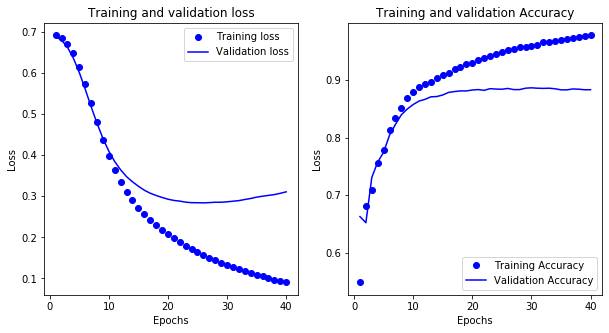

In [51]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1, 2)

# "bo" is for "blue dot"
axes[0].plot(epochs, loss, 'bo', label = 'Training loss')

# "b" is for "solid blue line"
axes[0].plot(epochs, val_loss, 'b', label = 'Validation loss')
axes[0].title.set_text('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()


# "bo" is for "blue dot"
axes[1].plot(epochs, acc, 'bo', label = 'Training Accuracy')

# "b" is for "solid blue line"
axes[1].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
axes[1].title.set_text('Training and validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()


plt.show()

从损失图像可以看出，validate accuracy 在大约 20 个周期后达到了峰值。后面就会出现一种过拟合的现象。我们要防止出现这种问题。